In [4]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from fractions import Fraction
import time
import sys

dyn_pendulum = {"g":9.81, "m": 1.0, "l": 1.0}
x0 = np.array([0.1, 0.0])
v1 = np.array([1.0, 0.0])
v2 = np.array([0.0, 1.0])
x_dot = []
x_norm = []
# cum = np.array([0,0,0])

# def cosin 

def simple_pendulum (x0, dyn):
    g = dyn['g'] 
    l = dyn['l']
    #print (x0)
    return np.array([x0[1], (-g/l)*np.sin(x0[0])])

def linearized_simple_pendulum (x0, dyn, y_pendulum):
    g = dyn['g'] 
    l = dyn['l']
    #print (x0)
    return np.array([0*x0[0] + 1*x0[1],
                     (-g/l)*np.cos(y_pendulum[0])*x0[0] + 0*x0[1]])

# def linearized_simple_pendulum (x0, dyn, y_pendulum):
#     g = dyn['g'] 
#     l = dyn['l']
#     #print (x0)
#     return np.array([0*x0[0] + (-g/l)*np.cos(y_pendulum[0])*x0[1],
#                      1*x0[0] + 0*x0[1]])

def RungeKutta_for_collect_trajectory (dyn, f, dt, x0):
    k1 = f(x0, dyn) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn)
    k3 = f(x0 + 0.5*k2*dt, dyn)
    k4 = f(x0 + k3*dt, dyn)
    
    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) *dt
    x_norm.append(x0)
    x_dot.append(k4)
    return x

def RungeKutta (dyn, f, dt, x0):
    k1 = f(x0, dyn) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn)
    k3 = f(x0 + 0.5*k2*dt, dyn)
    k4 = f(x0 + k3*dt, dyn)
    
    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) *dt
    return x

def RungeKutta_linearized (dyn, f, dt, x0, y):
    k1 = f(x0, dyn, y) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn, y)
    k3 = f(x0 + 0.5*k2*dt, dyn, y)
    k4 = f(x0 + k3*dt, dyn, y)
    
    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) * dt

    return x

def f_t_collect_trajectory  (dyn, f, linearized_f, dt, x0, T):
    x = np.empty(shape=(len(x0),T))
    v1_prime = np.empty(shape=(len(x0),T))
    v2_prime = np.empty(shape=(len(x0),T))
    v3_prime = np.empty(shape=(len(x0),T))
    x[:, 0] = x0
    v1_prime[:, 0] = v1
    v2_prime[:, 0] = v2
    cum = np.array([0,0,0])
    for i in range(1,T):
        x[:, i] = RungeKutta_for_collect_trajectory(dyn, f, dt, x[:, i-1])
        
        v1_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v1_prime[:, i-1], x[:, i-1])
        v2_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v2_prime[:, i-1], x[:, i-1])
        v3_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v3_prime[:, i-1], x[:, i-1])
        
        
        norm1 = np.linalg.norm(v1_prime[:, i])
        v1_prime[:, i] = v1_prime[:, i]/norm1
        
        GSC1 = np.dot(v1_prime[:, i], v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i] - GSC1*v1_prime[:, i]
        
        norm2 = np.linalg.norm(v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i]/norm2
        
#         GSC2 = np.dot(v3_prime[:, i], v1_prime[:, i])
#         GSC3 = np.dot(v3_prime[:, i], v2_prime[:, i])
        
#         v3_prime[:, i] = v3_prime[:, i] - GSC2*v1_prime[:, i] - GSC3*v2_prime[:, i]
#         norm3 = np.linalg.norm(v3_prime[:, i])
#         v3_prime[:, i] = v3_prime[:, i]/norm3

        cum = cum + np.log2(np.array([norm1,norm2]))
#         if ( i % 100 == 0 ):
#             print ('log2:', np.log2(np.array([norm1,norm2,norm3]))/(i*dt))
#             print ('cum:', cum/(i*dt))
        
        
    return x, cum/(i*dt)


def f_t (dyn, f, linearized_f, dt, x0, T):
    x = np.empty(shape=(len(x0),T))
    v1_prime = np.empty(shape=(len(x0),T))
    v2_prime = np.empty(shape=(len(x0),T))
    x[:, 0] = x0
    v1_prime[:, 0] = v1
    v2_prime[:, 0] = v2
    cum = np.array([0,0])
    
    for i in range(1,T):
        x[:, i] = RungeKutta(dyn, f, dt, x[:, i-1])
        
        v1_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v1_prime[:, i-1], x[:, i-1])
        v2_prime[:, i] = RungeKutta_linearized(dyn, linearized_f, dt, v2_prime[:, i-1], x[:, i-1])
        
        norm1 = np.linalg.norm(v1_prime[:, i])
        v1_prime[:, i] = v1_prime[:, i]/norm1
        
        GSC1 = np.dot(v1_prime[:, i], v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i] - GSC1*v1_prime[:, i]
        
        norm2 = np.linalg.norm(v2_prime[:, i])
        v2_prime[:, i] = v2_prime[:, i]/norm2
        

        cum = cum + np.log2(np.array([norm1,norm2]))
#         print("total time taken this loop: ", end_time - start_time)
    cum = cum/(T*dt)
    return max(cum)

In [2]:
_, cum = f_t(dyn_pendulum, simple_pendulum, linearized_simple_pendulum, 0.001, np.array([np.pi,0]), 500)

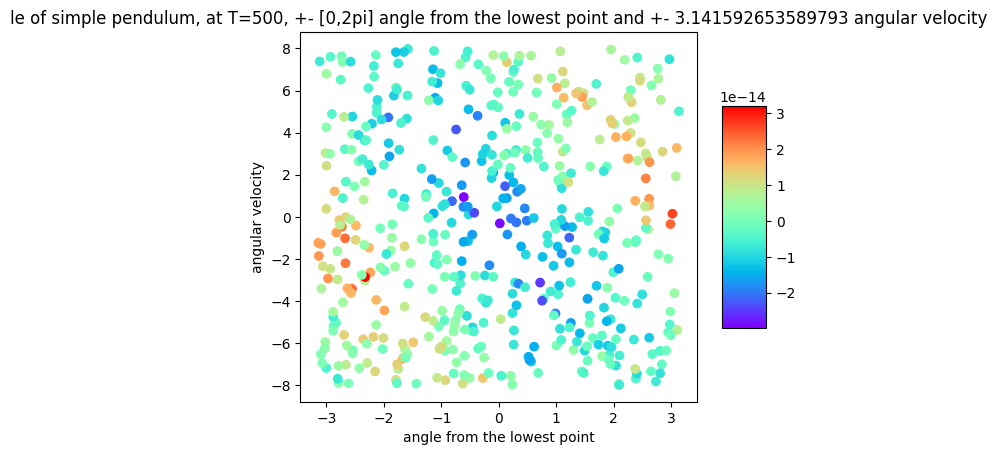

In [38]:
ra = np.pi
rv = 8
T = 500
test = np.array([  np.random.uniform(-ra, ra, size=(500)), 
                 np.random.uniform(-rv, rv, size=(500))])
new_test = np.append(test.T,np.array([[np.pi,0]]),axis=0)

cum_list = []
for i in test.T:
    _, cum = f_t(dyn_pendulum, simple_pendulum, linearized_simple_pendulum, 0.001, i, T)
    cum_list.append(cum)
    
fig = plt.figure()
ax = fig.add_subplot(111)
zs = np.array([np.sum(i) for i in cum_list])
plot1 = ax.scatter(test[0], test[1], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
ax.set_xlabel('angle from the lowest point')
ax.set_ylabel('angular velocity')
plt.title ('le of simple pendulum, at T={}, +- [0,2pi] angle from the lowest point and +- {} angular velocity'.format(T,ra,rv))
plt.show()

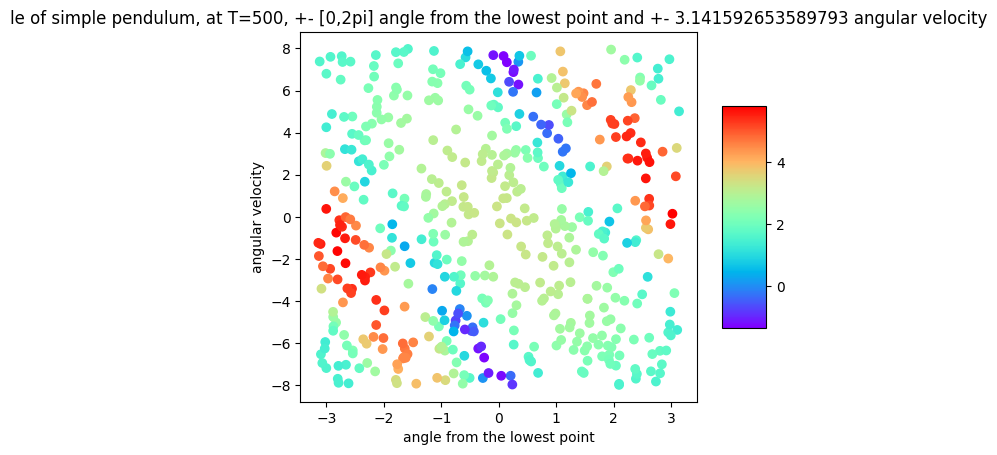

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
zs = np.array([i[0] for i in cum_list])
plot1 = ax.scatter(test[0], test[1], c=zs, cmap=plt.cm.rainbow,vmin=zs.min(), vmax=zs.max())
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
ax.set_xlabel('angle from the lowest point')
ax.set_ylabel('angular velocity')
plt.title ('le of simple pendulum, at T={}, +- [0,2pi] angle from the lowest point and +- {} angular velocity'.format(T,ra,rv))
plt.show()

In [20]:
X = np.array(np.meshgrid(np.arange(0 , 2*np.pi, 0.2),
                      np.arange(-8 , 8, 0.2)))

In [29]:
len(np.arange(0 , 2*np.pi, 0.2))

32

In [21]:
X_reshaped = X.T.reshape(X.T.shape[0]*X.T.shape[1],2)

In [11]:
le_collection = []
for i in X_reshaped:
    le_collection.append(f_t(dyn_pendulum, simple_pendulum, linearized_simple_pendulum, 0.001, i, 500))


KeyboardInterrupt



In [12]:
X_reshaped.shape

(10080, 2)

In [9]:
from scipy import spatial
from concurrent.futures import ProcessPoolExecutor

In [48]:
pt = np.array([np.pi,0.0])

In [49]:
X_reshaped[spatial.KDTree(X_reshaped).query(pt)[1]]

array([ 3.10000000e+00, -2.84217094e-14])

In [51]:
spatial.KDTree(X_reshaped).query(pt)

(0.04159265358979303, 5040)

In [54]:
X_reshaped[5040]

array([ 3.10000000e+00, -2.84217094e-14])

In [56]:
le_collection[5040]

5.832325449434139

In [28]:
f_t(dyn_pendulum, simple_pendulum, linearized_simple_pendulum, 0.001, [ 0. , -8. ], 500)

1.3760484296332407

In [10]:
def cal_le (x):
    le = f_t(dyn_pendulum, simple_pendulum, linearized_simple_pendulum, 0.001, x, 500)
    return x, le

In [22]:
np.save('precal_pendulum_points_02', X_reshaped)

In [23]:
points = list(X_reshaped)
f = open("precal_pendulum_02.txt", "w")
with ProcessPoolExecutor(max_workers=6) as executor:
    for r in executor.map(cal_le, points, chunksize=10):
        f.write(',' + str(r[1]))
f.close()

In [24]:
here = np.loadtxt("precal_pendulum_02.txt", delimiter=',')

In [25]:
here

array([1.37604843, 1.46802858, 1.41440836, ..., 0.78646562, 1.09810464,
       1.34750971])

In [15]:
!sed -r '1s/^.{1}//' precal_pendulum.txt >> precal_pendulum_01.txt

In [27]:
X.shape

(2, 80, 32)